# Exercise of WIC
Intelligent Embedded Systems Lab, University of Freiburg

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Contact: Lena Uhlenberg lena.uhlenberg@informatik.uni-freiburg.de

March, 2023

## Introduction
In the previous exercise, we have implemented a detector for three daily activites. Our detector models however were not trained using null-class, and in the online detection scenario we applied a threshold on the posteriors yielded by the classifier to predict the null-class. Nevertheless, there are more ways to model the null-class.

In this exercise, we want to train a class support vector machine (SVM) model from raw sensor recordings identifying the null class. A challenge is to find suitable features and window sizes to achieve best performance of the model.


## Learning objectives


1. Understand the role of null-class in activity detection.
2. Understand the concept of One-Class SVM.
3. Apply One-Class SVM to seperate the null-class from another activity class.

## Procedure
1. Follow the notebook and understand the code structure to implement a One-Class Support Vector Machine (SVM) model to seperate the null-class from another activity class.

## Data

We use the raw data collected for the paper
*Florian Wahl, Martin Freund, Oliver Amft, "WISEglass: Smart eyeglasses recognising context", EAI Endorsed Transactions on Pervasive Health and Technology, eudl.eu, 2015*. PDF at the bottom of the page: 
https://www.cdh.med.fau.de/publications/?id=FHX48BI6.<br>

The original dataset includes a number of activities that can be mainly categorized into four classes: "Eating", "Walking", "Sedentary" and "Null". 

For example, 
- 0: "Null" includes all other activities than the listed activities below, e.g. brushing teeth, biking, cleaning room
- 1: "Eating" includes breakfast, lunch and dinner; 
- 2: "Walking" includes walking at different speeds and climbing stairs;
- 3: "Sedentary" includes reading, computer work, and watching movie, etc., where participants were sitting. 


In this exercise, the raw data have been reduced to only 6-channel IMU (3-axis gyroscope and 3-axis acceleration sensors) and is annotated with four class labels (see above). Feature extraction follows the sliding window implementation of last exercise, but this time including the null-class. Features are computed over all the sensor channels. The features can be normalized. 



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
import warnings
import pickle
import os
import pandas as pd
import seaborn as sns
import h5py
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Feature extraction including null-class
The code block below is only used to create new datasets

In [2]:

headers=pickle.load(open(os.path.join(os.getcwd(), "data","headers.pkl"),"rb"))
def feature_cal(window):
    fv = []
    x = np.array(window).T
    for i in range(x.shape[0]):
        mean_ = np.mean(x[i])
        std_ = np.std(x[i])
        max_ = np.max(x[i])
        min_ = np.min(x[i])
        zcr_ = (np.diff(np.sign(x[i])) != 0).sum()
        fluc_ = mean_ / std_
        min_max_ = max_ - min_
        sum_ = np.sum(x[i])
        pos_sum_ = np.sum(x[i][x[i] > 0])
        neg_sum_ = np.sum(x[i][x[i] < 0])
        abs_sum_ = np.sum(np.abs(x[i]))
        diff_sum_ = np.sum(np.diff(x[i]))
        diff_pos_sum_ = np.sum(np.diff(x[i][x[i] > 0]))
        diff_neg_sum_ = np.sum(np.diff(x[i][x[i] < 0]))
        diff_diff_sum_ = np.sum(np.diff(np.diff(x[i])))
        diff_diff_abs_sum_ = np.sum(np.diff(np.diff(np.abs(x[i]))))
        diff_diff_pos_sum = np.sum(np.diff(np.diff(np.abs(x[i][x[i] > 0]))))
        diff_diff_neg_sum = np.sum(np.diff(np.diff(np.abs(x[i][x[i] < 0]))))
        rms_ = np.sqrt(np.sum(x[i]**2))
        energy_ = np.sum(x[i]**2) / win_len

        fv.extend([mean_, std_, max_, min_, zcr_, fluc_, min_max_, sum_, 
                   pos_sum_, neg_sum_, abs_sum_, diff_sum_, diff_pos_sum_, 
                   diff_neg_sum_, diff_diff_sum_, diff_diff_abs_sum_, 
                   diff_diff_pos_sum, diff_diff_neg_sum, rms_, energy_])
    return np.array(fv)


# Sliding window implementation with 4 classes
clf_list, win_len, win_step = [], 1500, 50 # len = 30 seconds, step = 15s
for test_pid in [2, 4, 5, 8, 9]:
    pid_pool = [2, 4, 5, 8, 9]
    pid_pool.remove(test_pid)
    x_train, y_train = [], []
    for train_pid in pid_pool:
        
        # Load data
        hf = h5py.File(r'data/data_E4_TS_' + str(test_pid) + '.h5', 'r')
        train_data = hf['data'][:]
        hf.close()

        # Split training data by class
        c1, c2, c3,c4 = [], [], [],[]
        for i in range(len(train_data)):
            if train_data[i, 6] == 1:
                c1.append(train_data[i, :6])
            elif train_data[i, 6] == 2:
                c2.append(train_data[i, :6])
            elif train_data[i, 6] == 3:
                c3.append(train_data[i, :6])
            else:
                c4.append(train_data[i, :6]) # Null-class

        class_id = 1
        for c in [c1, c2, c3, c4]:
            j = 0
            for i in range(len(c)):
                if j > len(c) - win_len - 1:
                    break
                else:
                    x_train.append(feature_cal(c[j: j + win_len]))
                    y_train.append(class_id)
                    j += win_step
            class_id += 1

    x_normalized, max_norm, min_norm = [], [], []

    for col in range(len(x_train[0])):
        f_i = np.array([row[col] for row in x_train])
        max_norm.append(np.max(f_i))
        min_norm.append(np.min(f_i))
    max_norm = np.array(max_norm)  
    min_norm = np.array(min_norm)
    x_normalized = (x_train - min_norm) / (max_norm - min_norm)
    
    y_train_rep=[0 if x==4 else x for x in y_train]
    raw_features=pd.DataFrame(x_train, columns=headers)
    raw_features['label']=y_train_rep
    raw_features['Participant']=test_pid
    
    #save per subject data
    pickle.dump(raw_features, open(os.path.join(os.getcwd(), "data","raw_features_"+str(win_len)+"_"+str(win_step)+"_"+str(test_pid)+".pkl"),"wb"))

# Load subject data
all_dataframes=[]
for test_pid in [2, 4, 5, 8, 9]:
    all_data=pickle.load(open(os.path.join(os.getcwd(),"data", "raw_features_"+str(win_len)+"_"+str(win_step)+"_"+str(test_pid)+".pkl"),"rb"))
    all_dataframes.append(all_data)
all_data_big=pd.concat(all_dataframes, axis=0).reset_index(drop=True)

#save all participants in one file
pickle.dump(all_data_big, open(os.path.join(os.getcwd(), "data", "raw_features_"+str(win_len)+"_"+str(win_step)+".pkl"),"wb"))    

## Feature inspection

We provide five datasets with different sliding window lenghts and step sizes. Please try them out and/or create new datasets to see changes in model performance (find code above).

In [3]:
# Load data
win_len, win_step = 3000, 1500 # also in data folder: 1500, 150; 4500,750; 1500,750; 1500,50
data=pickle.load(open(os.path.join(os.getcwd(),"data", "raw_features_"+str(win_len)+"_"+str(win_step)+".pkl"),"rb"))
    
# Print data
data

,maccelX_mean,maccelY_mean,maccelZ_mean,mgyroX_mean,mgyroY_mean,mgyroZ_mean,maccelX_var,maccelY_var,maccelZ_var,mgyroX_var,...,mgyroY_rms,mgyroZ_rms,maccelX_energy,maccelY_energy,maccelZ_energy,mgyroX_energy,mgyroY_energy,mgyroZ_energy,label,Participant
0,-13631.436000,1405.064522,-10016.0,-19792.0,0.0,-9.701644,9776.0,-40894308.0,0.0,-40894308.0,...,74.0,-64.0,34.0,34.0,34.0,-251.0,11233.548682,42064.205333,1,2
1,-14562.322667,1267.923010,-9148.0,-19792.0,0.0,-11.485179,10644.0,-43686968.0,0.0,-43686968.0,...,206.0,44.0,119.0,143.0,121.0,3.0,15537.281712,80469.041000,1,2
2,-14684.776000,1102.338830,-9148.0,-18872.0,0.0,-13.321472,9724.0,-44054328.0,0.0,-44054328.0,...,-147.0,60.0,-43.0,59.0,-20.0,-24.0,17768.052960,105234.568667,1,2
3,-14130.265333,1138.341687,-9952.0,-18536.0,0.0,-12.413026,8584.0,-42390796.0,0.0,-42390796.0,...,-158.0,1.0,49.0,49.0,49.0,-109.0,17034.599320,96725.858000,1,2
4,-13709.180000,1188.331101,-9536.0,-17128.0,0.0,-11.536499,7592.0,-41127540.0,0.0,-41127540.0,...,-1.0,37.0,76.0,-70.0,-26.0,-62.0,14776.325863,72779.935333,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17507,-15459.080000,351.128279,-8796.0,-20020.0,0.0,-44.026873,11224.0,-46377240.0,0.0,-46377240.0,...,0.0,0.0,0.0,0.0,0.0,0.0,501.752927,83.918667,0,9
17508,-15458.476000,351.269162,-8796.0,-20020.0,0.0,-44.007495,11224.0,-46375428.0,0.0,-46375428.0,...,0.0,1.0,-1.0,1.0,0.0,1.0,501.719045,83.907333,0,9
17509,-15468.606667,94.892838,-14456.0,-16928.0,0.0,-163.011320,2472.0,-46405820.0,0.0,-46405820.0,...,0.0,-1.0,1.0,-1.0,0.0,-1.0,502.267857,84.091000,0,9
17510,-15469.141333,102.205434,-14456.0,-16928.0,0.0,-151.353414,2472.0,-46407424.0,0.0,-46407424.0,...,0.0,0.0,1.0,-1.0,0.0,-1.0,501.672204,83.891667,0,9


## Class and feature selection

Our goal is to separate the null class from an activity class (in the example the walking class). Therefore, the data must be adjusted and two of the three activity classes must be excluded.

In [4]:
# Null-class vs. walking
include=2       # walking class
ex1=1           # exlude eating clas
ex2=3           # exclude sedentary class
data_no = data[data.label != ex1]
data_no = data_no[data_no.label != ex2]

## Train the one class support vector machine (SVM) model
One-Class Support Vector Machine (SVM) is an unsupervised model for outlier detection. Unlike the regular supervised SVM, the one-class SVM does not have target labels for the model training process. Instead, it learns the boundary for the normal data points and identifies the data outside the border as outliers.

When training the one-class SVM, there are a few critical hyperparameters.
1. nu: specifies the percentage of anomalies. nu=0.05 means that we have around 5% outliers in the dataset.
    
2. Kernel: specifies the kernel type. The radial basis function (rbf) kernel is a commonly used kernel type. 
   It maps data from a low dimensional space to a high dimensional space to help the SVM model draw a decision boundary.
    
3. gamma: specifies kernel coefficient, e.g., 'rbf', 'poly', and 'sigmoid' kernels. When setting it to 'auto', 
   the kernel coefficient is 1 over the number of features.

In [46]:
#train with best features, you can also exchange and modify features here
feature_best=['maccelX_mean', 'maccelY_mean', 'maccelZ_mean', 'mgyroX_mean',
       'mgyroY_mean', 'mgyroZ_mean', 'maccelX_var',
       'maccelY_var', 'maccelZ_var', 'mgyroX_var', 'mgyroY_var', 'mgyroZ_var',
        'maccelX_max', 'maccelY_max', 'maccelZ_max',
       'mgyroX_max', 'mgyroY_max', 'mgyroZ_max', 
       'maccelX_min', 'maccelY_min', 'maccelZ_min', 'mgyroX_min', 'mgyroY_min',
       'mgyroZ_min']

#Take only best discriminating features for one-class SVM
data_1=data_no[ feature_best].to_numpy()# select best two

data_y=data_no['label'].to_numpy()# Split training and testing set 
X_train, X_test, y_train, y_test = train_test_split(data_1, data_y, test_size=0.2, random_state=42)# Check the number of records

print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")

# Implementation: change input to see differnt outputs
one_class_svm = OneClassSVM(nu=0.2, kernel = 'rbf', gamma = 'auto').fit(X_train)

#Short cut with already trained model: 3000, 1500 # also in data folder: 1500, 150; 4500,750; 1500,750; 1500,50
#one_class_svm=pickle.load(open(os.path.join(os.getcwd(), "data", "OCsvm_"+str(win_len)+"_"+str(win_step)+".pkl"),"rb"))

The number of records in the training dataset is 9696
The number of records in the test dataset is 2424
The training dataset has 9378 records for the majority class and 318 records for the minority class.


## Predictions
After training the one-class SVM model on the training dataset, we make predictions on the testing dataset. 
By default, one-class SVM labels the normal data points as 1s and outliers as -1s. To compare the labels with the ground truth in the testing dataset, we changed the outliers’ labels from -1 to class, and the normal labels from 1 to 0.

In [47]:
# Prediction

prediction = one_class_svm.predict(X_test)# Change the anomalies' values to make it consistent with the true values
prediction = [0 if i==-1 else include for i in prediction]# Check the model performance
print(classification_report(y_test, prediction))


              precision    recall  f1-score   support

           0       0.98      0.65      0.78      2358
           2       0.04      0.52      0.07        66

    accuracy                           0.64      2424
   macro avg       0.51      0.58      0.43      2424
weighted avg       0.95      0.64      0.76      2424



## Customized predictions
Instead of using the default threshold for identifying outliers, we can customize the threshold and label more or fewer data points as outliers. For example, in the code below, we find the score for 12% of the data points and use it as the prediction threshold.

In [48]:
score = one_class_svm.score_samples(X_test)# Check the score for 12% of outliers
score_threshold = np.percentile(score, 12)# vary the percentage of ourliers
print(f'The customized score threshold for 12% of outliers is {score_threshold:.12f}')# Check the model performance at 2% threshold
customized_prediction = [include if i < score_threshold else 0 for i in score]# # Check the prediction performance
print(classification_report(y_test, customized_prediction))

The customized score threshold for 12% of outliers is 0.640625000000
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2358
           2       0.00      0.00      0.00        66

    accuracy                           0.96      2424
   macro avg       0.49      0.50      0.49      2424
weighted avg       0.95      0.96      0.96      2424



## Visualisation
We will plot the data points and check the differences between actual, one-class SVM prediction and customized one-class SVM prediction.

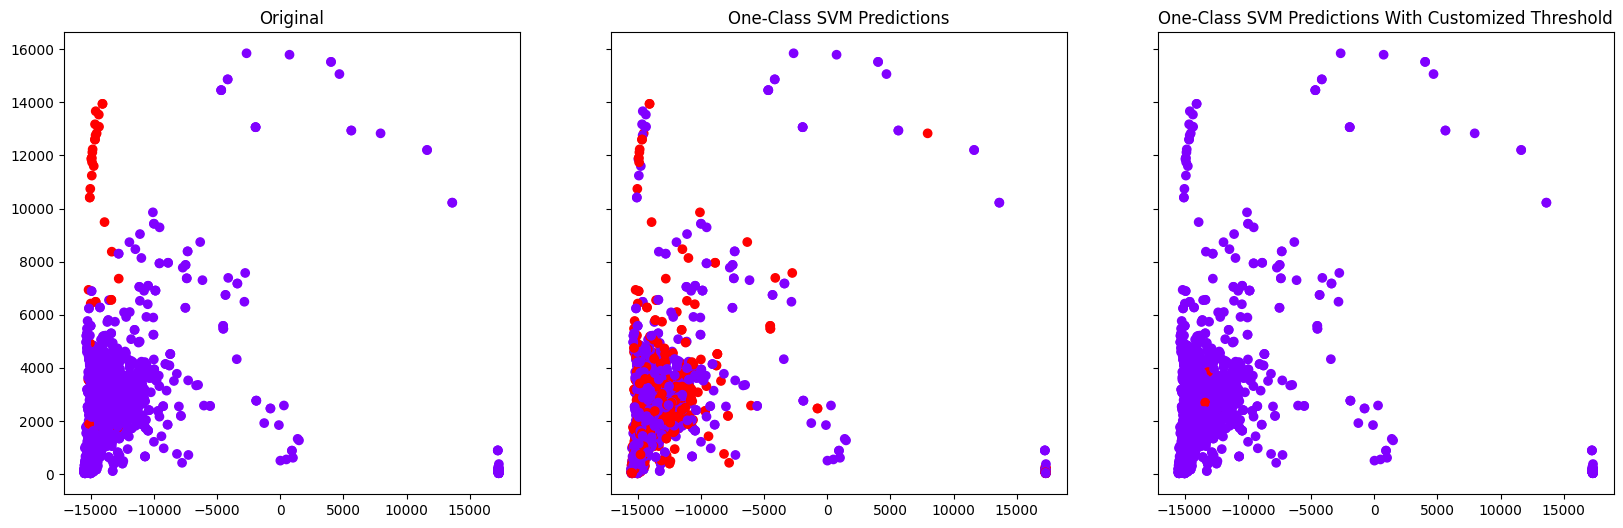

In [49]:
df_test = pd.DataFrame(X_test[:, 0:2])# select features (columns) you want to consider for plotting
df_test['y_test'] = y_test
df_test['one_class_svm_prediction'] = prediction
df_test['one_class_svm_prediction_cutomized'] = customized_prediction# Visualize the actual and predicted anomalies
fig, (ax0, ax1, ax2)=plt.subplots(1,3, sharey=True, figsize=(20,6))# Ground truth
ax0.set_title('Original')
ax0.scatter(df_test.iloc[:, 0:1],df_test.iloc[:, 1:2], c=df_test['y_test'], cmap='rainbow')# One-Class SVM Predictions using the first two featurs
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test.iloc[:, 0:1],df_test.iloc[:, 1:2], c=df_test['one_class_svm_prediction'], cmap='rainbow')# One-Class SVM Predictions With Customized Threshold
ax2.set_title('One-Class SVM Predictions With Customized Threshold')
ax2.scatter(df_test.iloc[:, 0:1],df_test.iloc[:, 1:2], c=df_test['one_class_svm_prediction_cutomized'], cmap='rainbow')
plt.show()


## Questions

Please answer directly in this code block.

#### 1. What are possible reasons for a poor prediction result? Please name 3 reasons. 
Answer: One reason for the poor performance can be attributed to the fact that the data might be non-linearly separable. SVM assumes that data can be seperated by a hyperplane as features belonging to the same class will be in a cluster. However, in many real-world problems, data is often not linearly separable. RBF can handle non-linear separable data but if the data is too complex or if there are too many outliers, the model will not perform well.


## Submission
Make sure all coding tasks are completed, code blocks are executed, and all questions are answered.<br>
Enter your name(s) and matriculation number(s) here:<br>
**Name(s)**:       Sidharth Suresh, Sanskar Biswal                     <br>
**Matriculation number(s)**:         5583120, 5585853                     <br>